In [56]:
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
import torch.utils.data
import torch.nn as nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

In [68]:
# Load the data into a DataFrame if necessary
from pandas import DataFrame
from sklearn.discriminant_analysis import StandardScaler


def load_data(dataset:int): 
    """
    loads data into pd dataFrame. either original or pca

    Args:
        dataset (int): 0 = original data, 1 = PCA data
    """

    data_orig = pd.read_csv(filepath_or_buffer='final_data_only_tpm.csv')

    data_pca = pd.read_csv(filepath_or_buffer='pca_data.csv')
    data_pca.drop(data_pca.columns[0], axis=1, inplace=True)

    # choose dataset according to user input (parameter dataset)
    if dataset==0:
        print("loading original data")
        data = data_orig 
    else: 
        print("loading pca data")
        data = data_pca

    # change ctargel col "cancer_type" from string label to int val
    map = {
        "kidney chromophobe": 0,
        "kidney renal papillary cell carcinoma": 1,
        "kidney renal clear cell carcinoma": 2,
    }
    data1 = data.copy()
    data1['cancer_type'] = data1['cancer_type'].replace(map)
    
    return data1

def split_data(data: DataFrame, normalize=False):
    """
    returns Train Test splittet Tensors

    Args:
        data (pd Dataframe): whole dataset

    Returns:
        torch tensor: 4-tuple of train test data
    """
    # Split the data into training and validation sets
    train_dataset, test_dataset = train_test_split(data, test_size=0.2, random_state=42)

    # dataloader
    batch_size = 128
    train_dataloader = DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True
    )
    val_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size)

    # or

    # Split the data into features (X) and target variable (y)
    X = data.drop('cancer_type', axis=1)
    
    y = data['cancer_type']

    X_train_pd, X_test_pd, y_train_pd, y_test_pd = train_test_split(X, y, test_size=0.2)#, random_state=42)

    # normalizing data: no effect for pca
    if normalize:
        scaler = StandardScaler()
        X_train_pd =  pd.DataFrame(scaler.fit_transform(X_train_pd))
        X_test_pd =  pd.DataFrame(scaler.fit_transform(X_test_pd))

    X_train_tens = torch.tensor(X_train_pd.values).float()
    X_test_tens = torch.tensor(X_test_pd.values).float()
    y_train_tens = torch.tensor(y_train_pd.values)
    y_test_tens = torch.tensor(y_test_pd.values)

    return (X_train_tens, X_test_tens, y_train_tens, y_test_tens)

# load anyway
#data = load_data(1)

# load if necessary
try:
    data                 # its ok that this var is not defined 
except NameError:
    data = load_data(0)

X_train, X_test, y_train, y_test = split_data(data)

data.head(1)

,0,1,2,3,4,5,6,7,8,9,...,1019,1020,1021,1022,1023,1024,1025,1026,1027,cancer_type
0,-50.539464,37.720744,95.031868,13.494568,3.609478,2.766656,-0.211304,15.262947,28.740613,-15.973821,...,-0.991685,-1.491184,-0.976384,0.471,-0.184938,0.563093,-0.849205,-0.133114,9.100556e-15,0


In [74]:
torch.manual_seed(42)

# Variables
HIDDEN_UNITS = 8
NUM_FEATURES = X_train.shape[1]     # pca=1028 orig=60660
NUM_CLASSES = 3                     # cancer types
DEVICE = "cpu"
LR = 0.001                          # learning Rate
EPOCHS = 100

In [75]:
# Build model
class MultiClassificationModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()

        """ n_input_channels = 3  # i.e., length of our OHE scheme
        n_filters = 32  # i.e., no. of kernels
        kernel_size = 3
        conv_out_len = output_features - kernel_size + 1
        self.net = nn.Sequential(
            nn.Conv1d(
                in_channels=n_input_channels,
                out_channels=n_filters,
                kernel_size=kernel_size,
            ),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(in_features=n_filters * conv_out_len, out_features=1),
        ) # sizes don't add up.. "Given groups=1, weight of size [32, 3, 3], expected input[1, 822, 60660] to have 3 channels, but got 822 channels instead" """


        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            #nn.Sigmoid(),
            #nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
            #nn.Softmax(dim=1)
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)


# Calculate accuracy (a classification metric)
def accuracy_fn_alt(y_true, y_logits):
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

def accuracy_fn_neu(y_true, y_logits):
    _, predicted = torch.max(y_logits, 1)# go from logits -> prediction probabilities -> prediction labels
    correct = (predicted == y_true).sum().item()
    accuracy = correct / y_true.size(0)
    return accuracy * 100

accuracy_fn = accuracy_fn_neu

In [76]:
# Create an instance of Model and send it to the target device
model = MultiClassificationModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES, hidden_units=8).to(DEVICE)

# Put data to target device
X_train, y_train = X_train.to(DEVICE), y_train.to(DEVICE)
X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)

# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)

## model pre testing
""""""
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
print(model(X_train.to(DEVICE))[:5])
print(model(X_train.to(DEVICE))[0].shape, NUM_CLASSES , "\n")

# Make prediction logits with model
y_logits_train = model(X_test.to(DEVICE))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits_train, dim=1) 
print(y_logits_train[:5])
print(y_pred_probs[:5], "\n")

# Sum the first sample output of the softmax activation function 
print(torch.sum(y_pred_probs[0]), "\n")

# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]), "\n")

tensor([[ 2.2846, -2.6682,  1.7183],
        [ 1.5467, -0.4693,  0.9995],
        [ 5.4746, -5.0618,  3.3223],
        [ 1.3842,  0.6603,  0.0737],
        [ 4.2263, -4.5999,  4.3460]], grad_fn=<SliceBackward0>)
torch.Size([3]) 3 

tensor([[ 0.2721,  0.5647, -0.1868],
        [ 0.1980, -1.4051,  0.5552],
        [ 1.4585,  0.5502,  0.3253],
        [ 0.9795,  0.9627,  2.0513],
        [ 0.4050, -0.9095, -0.0375]], grad_fn=<SliceBackward0>)
tensor([[0.3365, 0.4509, 0.2126],
        [0.3801, 0.0765, 0.5433],
        [0.5796, 0.2337, 0.1866],
        [0.2039, 0.2005, 0.5956],
        [0.5233, 0.1406, 0.3362]], grad_fn=<SliceBackward0>) 

tensor(1.0000, grad_fn=<SumBackward0>) 

tensor([0.3365, 0.4509, 0.2126], grad_fn=<SelectBackward0>)
tensor(1) 



In [77]:
# Initialize lists to store training and test metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Fit the model

for epoch in range(EPOCHS):
    ### Training
    model.train()

    # 1. Forward pass
    y_logits_train = model(X_train)   # model outputs probabilities per prediction class

    # 2. Calculate loss and accuracy
    train_loss = loss_fn(y_logits_train, y_train) 
    train_acc = accuracy_fn(y_true=y_train, y_logits=y_logits_train)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    train_loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      y_logits_test = model(X_test)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(y_logits_test, y_test)
      test_acc = accuracy_fn(y_true=y_test, y_logits=y_logits_test)

      # Log metrics
      train_losses.append(train_loss.item())
      test_losses.append(test_loss.item())
      train_accuracies.append(train_acc)
      test_accuracies.append(test_acc)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Acc: {train_acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 1.79485, Acc: 25.79% | Test Loss: 1.82176, Test Acc: 20.39%
Epoch: 10 | Loss: 1.20103, Acc: 43.43% | Test Loss: 1.38149, Test Acc: 38.83%
Epoch: 20 | Loss: 0.92052, Acc: 56.08% | Test Loss: 1.17047, Test Acc: 44.66%
Epoch: 30 | Loss: 0.75169, Acc: 66.79% | Test Loss: 1.03659, Test Acc: 51.94%
Epoch: 40 | Loss: 0.63731, Acc: 73.36% | Test Loss: 0.93885, Test Acc: 57.77%
Epoch: 50 | Loss: 0.55139, Acc: 77.62% | Test Loss: 0.86228, Test Acc: 64.56%
Epoch: 60 | Loss: 0.48311, Acc: 80.17% | Test Loss: 0.80393, Test Acc: 67.96%
Epoch: 70 | Loss: 0.42883, Acc: 83.58% | Test Loss: 0.75857, Test Acc: 69.90%
Epoch: 80 | Loss: 0.38599, Acc: 85.64% | Test Loss: 0.72347, Test Acc: 71.84%
Epoch: 90 | Loss: 0.35183, Acc: 86.74% | Test Loss: 0.69489, Test Acc: 72.82%


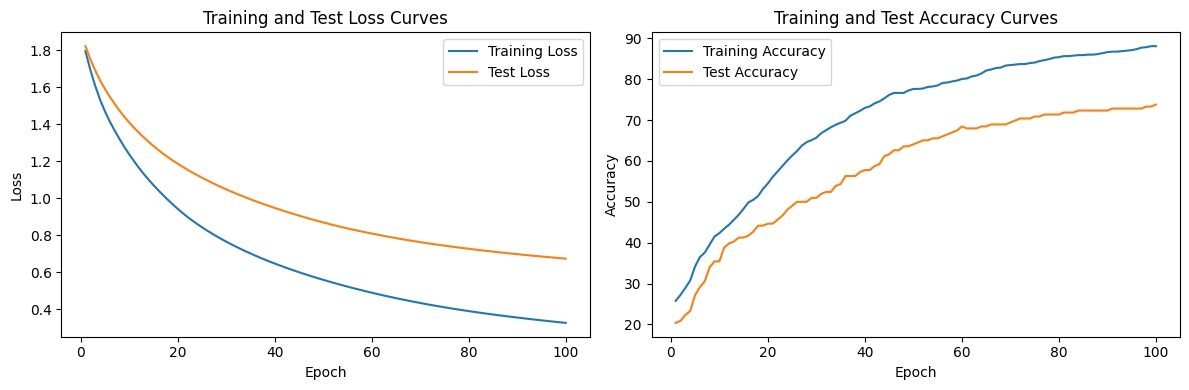

Training complete!


In [78]:
def plot_results(train_losses, test_losses, train_accuracies, test_accuracies, epochs=EPOCHS):
    plt.figure(figsize=(12, 4))

    # Plot Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Test Loss Curves')

    # Plot Accuracy Curves
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Test Accuracy Curves')

    plt.tight_layout()
    plt.show()

    print("Training complete!")

plot_results(train_losses, test_losses, train_accuracies, test_accuracies, epochs=EPOCHS)